# Residual Networks (ResNets)

Residual Networks (ResNets) were introduced in 2015 to address the issues faced when training very deep neural networks, such as the vanishing gradient problem. These networks use **residual blocks** with **skip connections**, which allow the network to pass information directly between layers.
If we use a shortcut that connects the layer $l$ and the layer $l+2$, the activation function becomes:
$$a^{[l+2]} = g(z^{[l+1]} + a^{[l]}) = g(w^{[l+2]} \cdot a^{[l+1]} + b^{[l+2]} + a^{[l]})$$

The addition of the skip connection term make weights be smaller, reducing the complexity of the network's learning. It is easier to copy $a^{[l]}$ to the activation of $a^{[l+2]}$, making it easier to learn the identity function.
If $z^{[l+1]}$ is zero, then $a^{[l+2]}$ is equal to $a^{[l]}$.

In this skipping blocks we are assuming that $a^{[l]}$ and $z^{[l+2]}$ are the same dimensions. This is the reason why in ResNet we often see `same` convolutions.

In case of different dimensions we can add a $w_s$ matrix to the formula in order to multiply $a^{[l]}$ and obtaining the same dimensions:
$$g(w^{[l+2]} \cdot a^{[l+1]} + b^{[l+2]} + w_s \cdot a^{[l]})$$

![Residual Network Architecture](https://www.researchgate.net/publication/344779798/figure/fig2/AS:948913762750466@1603250079903/The-architecture-of-our-deep-residual-network-ResNet-in-the-precise-stage-prediction.png)

# ResNet50
In this notebook I will be implementing the ResNet50 architecture by defining at first the identity block and the convolution block using TensorFlow.
After that I will use transfer learning to use a pretrained model to reduce the computational cost of training.

In [1]:
import numpy as np
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, UpSampling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
def identity_block(X, f, filters, initializer = random_uniform):
    """
    Implementation of the identity block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

In [3]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer,
                   also called Xavier uniform initializer.

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    #### MAIN PATH ####

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (3, 3), strides = (1, 1), padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])
    X = identity_block(X, 3,  [128,128,512])

    ## Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    ## Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [5]:
model = ResNet50(input_shape=(32,32,3), classes=10, training=True)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 38, 38, 64)     │          1,792 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 38, 38, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 38, 38, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 38, 38, 64)     │          4,160 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 38, 38, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 38, 38, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 38, 38, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 38, 38, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 38, 38, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 38, 38, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 38, 38, 256)    │         16,640 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 38, 38, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 38, 38, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 38, 38, 256)    │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 23,661,962 (90.26 MB)

 Trainable params: 23,608,842 (90.06 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [6]:
del model

# Transfer Learning with ResNet50v2 on Cifar10 dataset
Due to the high computational cost and the high RAM required to train the entire model, I will use a pretrained model, taken from `tensorflow` to predict labels.

## Dataset
I am using the Cifar-10 dataset. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes.

More on [Kaggle](https://www.kaggle.com/c/cifar-10).

![Cifar-10 dataset](https://datasets.activeloop.ai/wp-content/uploads/2022/09/CIFAR-10-dataset-Activeloop-Platform-visualization-image-1.webp)

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize images
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encoding
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


In [8]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224,224,3))
base_model.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
complete_model = Sequential([
        Input(shape=(32, 32, 3)),
        UpSampling2D(size=(7, 7)),
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation="relu"),
        Dropout(0.5),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

# Compile the model
complete_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

complete_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,192,906 (99.92 MB)

 Trainable params: 2,628,106 (10.03 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## Early Stopping and Learning Rate Decay
I am using an early stopping in order to prevent a long and useless training, in case the model will not improve for many epochs.
Using a learning rate decay will make the learning rate smaller through epochs, making the network be more precise once it will be close to the optimal value, leading to better results.

In [10]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

In [11]:
history = complete_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 180ms/step - accuracy: 0.7440 - loss: 0.7579 - val_accuracy: 0.8492 - val_loss: 0.4592 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 112s 143ms/step - accuracy: 0.8431 - loss: 0.4585 - val_accuracy: 0.8598 - val_loss: 0.4090 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 146ms/step - accuracy: 0.8658 - loss: 0.3984 - val_accuracy: 0.8604 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 114s 146ms/step - accuracy: 0.8740 - loss: 0.3650 - val_accuracy: 0.8691 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 112s 143ms/step - accuracy: 0.8818 - loss: 0.3416 - val_accuracy: 0.8678 - val_loss: 0.3791 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 147ms/step - accuracy: 0.8907 - loss: 0.3171 - val_accuracy: 0.8715 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 143ms/step -

# Results
After 18 epochs the early stopping made the network finish the training due to an increasing in the validation stop through the last 5 epochs.

The results obtained are the following:
- Training Accuracy: 96.65%
- Training Loss: 0.0924
- Validation Accuracy: 88.73%
- Validation Loss: 0.4388

By looking at the plot shown below we can clearly see a positive slope in validation loss in the last epochs, suggesting overfitting.
Using data augmentation can possibily lead to better results.

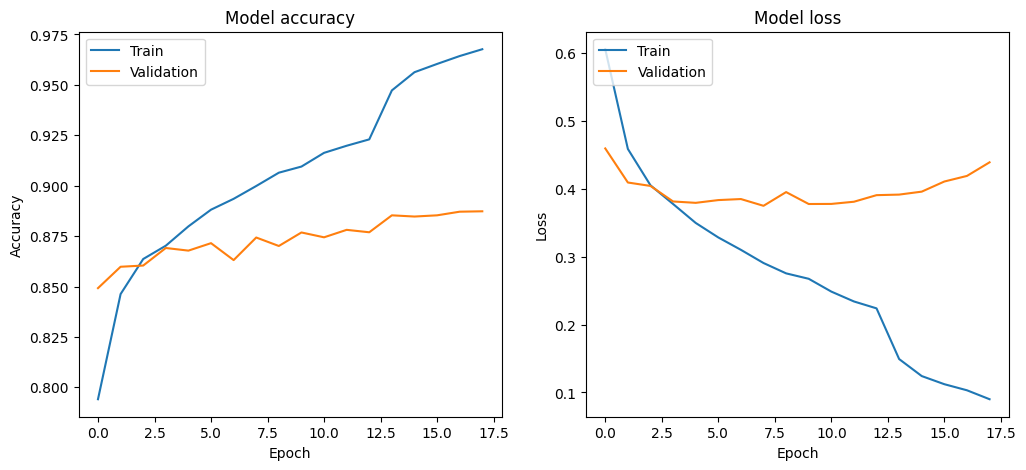

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [14]:
complete_model.save('ResNet_cifar10_model.h5')